# ECON 326 Group Final Report
#### Group 14 - Bhavya Dubey, Kashie Ugoji, Ruiquin Wang, Zhuoying Sun

## <u>Introduction<u>

When looking at the current nature of the financial markets, it is clear how much influence they have in our society. With around 63% of young adults (ages 18-34) **(remember to cite)** believing in building their wealth through the stock exchange, it shows how much of a focal point this aspect of our economy is for many people. More than ever, the ability to understand how the markets work and components that might affect it, is becoming an invaluable skill. With so much information readily available, it can sometimes feel like there is an oversaturated level of things that people must learn in order to form even a basic understanding of expected stock market performance. However, one of the basic things that people quickly realize, is that the collective sentiment of consumers and investors ultimately has a major influence on how markets perform.  

One of the phrases financial experts will say to people is to not "panic" during economic uncertainty as this may end up being the very origin of economic downturn. But how true is this claim? What if panicking and overall sentiments of fear are simply reactions to already existing economic instability caused by other factors, rather than potential indicators of future downturn in itself. For this research study, we explore this very topic. We are looking to explore the predictive nature that overall sentiments towards the economy can have on the stock market. More specifically, we want to see if **people's feelings of fear or uncertainty towards the economy can accurately predict stock market performance**. 

## <u>Data Description<u>

To conduct this analysis, we will be looking at data that is able to accurately quantify both the sentiment people have towards the economy, and also how stocks will be performing. 

### Fear Index Wrangling

We will quantify the **sentiment of "fear"** that people have towards the economy through **search-term data from Google Trends**. Google Trends uses relative popularity scores ranging from 0-100 in order to quantify how much a term was searched on google related platforms. A **popularity score of 100** would represent the peak amount a term was searched relative to its own history, and a **popularity score of 0** would represent the lowest amount a term was searched relatively. We will use the search terms **"recession"**, **"layoffs"** and **"stock crash"** spanning from **January 2004** (farthest timeline possible for Google Trends) to **April 2025** showing their monthly popularity scores as markers of fears. We chose these search terms as they are common terms people might search up when they are skeptical or worried about the economy. Using the `tidyverse` library, we will then make our own **"fear index"** where we will find the **mean** value of these collective popularity scores and use that as our explanatory variable for sentiment of fear towards the economy. 

We first load the `tidyverse` library

In [2]:
library(tidyverse) 

Warning message:
“package ‘lubridate’ was built under R version 4.4.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Now we can import our data from **Google Trends** with the files `layoffs.csv`, `recession.csv` and `stock crash.csv`

In [3]:
#Raw data for search-term "layoffs" (Jan 2004- April 2025)
layoffs_untidy <- read_csv("layoffs.csv", 
                    skip = 2)
#Raw data for search-term "recession" (Jan 2004- April 2025)
recession_untidy <- read_csv("recession.csv", 
                      skip = 2) 
#Raw data for search-term "stock crash" (Jan 2004- April 2025)
stock_crash_untidy <- read_csv("stock_crash.csv", 
                        skip = 2)

#Cleaning search-term data so that it is in a suitable format for future modelling 
stock_crash_tidy <- stock_crash_untidy |>
  mutate(term_date1 = ym(Month)) |>
  select(term_date1, `stock crash: (Canada)`) 

recession_tidy <- recession_untidy |>
  mutate(term_date2 = ym(Month)) |>
  select(term_date2, `recession: (Canada)`)

layoffs_tidy <- layoffs_untidy |>
  mutate(term_date3 = ym(Month)) |>
  select(term_date3, `layoffs: (Canada)`) 


Rows: 256 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Month
dbl (1): layoffs: (Canada)

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 256 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Month
dbl (1): recession: (Canada)

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 256 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Month
dbl (1): stock crash: (Canada)

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


With the cleaned data, we can make our **fear index**, showing it in through the variable `fear_value`

In [4]:
#Creating fear index
fear_index <- cbind(stock_crash_tidy, recession_tidy, layoffs_tidy) |>
  mutate(term_date = term_date1) |>
  select(term_date, `stock crash: (Canada)`, 
         `recession: (Canada)`,
         `layoffs: (Canada)`) |>
  mutate(fear_value = (`stock crash: (Canada)` + `recession: (Canada)` +
                         `layoffs: (Canada)`) / 3) |>
  filter(term_date < "2025-02-01")
head(fear_index)

,term_date,stock crash: (Canada),recession: (Canada),layoffs: (Canada),fear_value
,<date>,<dbl>,<dbl>,<dbl>,<dbl>
1,2004-01-01,24,3,6,11.000000
2,2004-02-01,14,0,8,7.333333
3,2004-03-01,23,0,8,10.333333
4,2004-04-01,36,4,8,16.000000
5,2004-05-01,28,3,5,12.000000
6,2004-06-01,18,0,0,6.000000


We will now make a new understanding of how to interpret these new values for `fear_value` using `quantile` to look at the percentiles of data

In [5]:
fear_metrics <- quantile(fear_index$fear_value, 
                         probs = c(0.25, 0.5, 0.75, 0.90, 0.95, 0.99)) 
fear_metrics

25%       50%       75%       90%       95%       99% 
 9.666667 13.000000 20.333333 30.266667 38.800000 49.440000

Based on the data, our interpretation for the **fear index** will go as follows: 

- **0-19**  is a low fear value
- **20-39** is a moderate fear value
- **40-49** is a high fear value
- **50+**   is an extremely high fear value


### Stock Performance Wrangling

We will quantify **stock performance** by looking at the **growth rate** of the overall stock market. In this study we will use the **S&P/TSX Composite Index** as our benchmark for the overall stock market, tracking **monthly** growth data in order to see how the market is performing. To view this, we will use data from **yahoo finance** through the library `quantmod`, which gives time-series data on any stock found on the market. Then we will use the `tidyverse` library to further wrangle and clean up the data.

First let's load the `quantmod` library

In [6]:
library(quantmod)

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that you type or       #
# source() into this session won't work correctly.                            #
#                                                                             #
# Use stats::lag() to make sure you're not using dplyr::lag(), or you can add #
# conflictRules('dplyr', exclude = 'lag') to your .Rprofile to stop           #
# dplyr from breaking base R's lag() function.                                #
#                                                                             #
# Code in packages is n

Now we import our stock performance data, keeping it in **monthly** increments and using **closing** values

In [7]:
#Raw data
getSymbols("^GSPTSE", src = "yahoo", from = "2004-01-01", to = "2025-02-01")
stock_monthly_untidy <- to.monthly(GSPTSE, indexAt = "firstof", OHLC = TRUE)

#Cleaning data 
stock_monthly_tidy <- fortify.zoo(stock_monthly_untidy) |>
  mutate(Date = Index) |>
  select(Date, GSPTSE.Close)
head(stock_monthly_tidy)

Warning message:
“^GSPTSE contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”


[1] "GSPTSE"

Warning message in to.period(x, "months", indexAt = indexAt, name = name, ...):
“missing values removed from data”


,Date,GSPTSE.Close
,<date>,<dbl>
1,2004-01-01,8521.4
2,2004-02-01,8788.5
3,2004-03-01,8585.9
4,2004-04-01,8244.0
5,2004-05-01,8417.3
6,2004-06-01,8545.6


We convert these price values into **growth rates** so we can see how much the stock price is changing each month

In [8]:
#Growth rates in percentages
stock_monthly_growth <- stock_monthly_tidy |>
  mutate(stock_growth = 
           ((GSPTSE.Close - lag(GSPTSE.Close)) / lag(GSPTSE.Close)) * 100)
head(stock_monthly_growth) 

,Date,GSPTSE.Close,stock_growth
,<date>,<dbl>,<dbl>
1,2004-01-01,8521.4,NA
2,2004-02-01,8788.5,3.134457
3,2004-03-01,8585.9,-2.305281
4,2004-04-01,8244.0,-3.982115
5,2004-05-01,8417.3,2.102133
6,2004-06-01,8545.6,1.524239


### Control Variables

We decided to choose these variables as our controls: 
- **inflation rate** - we want to control for the value of money as the level of inflation can influence earnings and stock valuations *(data is growth rate of CPI from a year-to-date in percentage)*
- **exchange rates** - we want to control for how much the CAD is worth relative to USD so that changes in the market aren't influenced by exchange rates through increased exports or imports *(data is nominal CAD/USD exchange rate)*
- **lagged monthly stock performance** - we want to control for the previous monthly market values so that previous values in the stock market are not influencing current market performance *(data is lagged monthly values of the S&P/TSX Composite Index)*
- **interest rates** we want to control for the interest rates as this affects how companies and consumers borrow money which has a notable influence on the stock market(*data is overnight rate of the first day of each month*) 
- **gdp growth** we want to control for periods of economic growth or slowdown as this may influence how the market performs(*data is monthly growth rate of real gdp in percentage*)
- **unemployment rates** we want to control for the level of employment in the economy as this factor can influences changes in the stock market through lower demand for goods and services during periods of high unemployment (*data is monthly unemployment rate in percentage*) 

First we import our data from `inflation.csv`, `exchange_rate.csv`, `interest_rate.csv`, `real_gdp_monthly.csv` and `unemployment_rate.csv` 

In [10]:
#For data wrangling of interest rate and gdp growth
library(zoo)

#Import inflation data
inflation_untidy <- read_csv("inflation.csv")
#Import exchange rate data
exchange_rate_untidy <- read_csv("exchange_rate.csv") 
#Import interest rate data 
interest_rate_untidy <- read_csv("interest_rate.csv") 
#Import gdp growth data 
gdp_untidy <- read_csv("real_gdp_monthly.csv")
#Import unemployment rate data 
unemploy_rate_untidy <- read_csv("unemployment_rate.csv") 

#Cleaning data for future modelling
inflation_tidy <- inflation_untidy |>
  mutate(inflation_rate = CPALTT01CAM659N,
         observation_date2 = observation_date) |>
  filter(observation_date2 > "2003-12-01") |>
  select(observation_date2, inflation_rate) 

exchange_rate_tidy <- exchange_rate_untidy |>
  mutate(exchange_rate = DEXCAUS,
         observation_date1 = observation_date) |>
  filter(observation_date1 > "2003-12-01",
         observation_date1 < "2025-02-01") |>
  select(observation_date1, exchange_rate)  

interest_rate_tidy <- interest_rate_untidy |>
  mutate(REF_DATE1 = ymd(REF_DATE)) |>
  filter(`Financial market statistics` == "Overnight money market financing") |>
  filter(REF_DATE1 > "2003-12-30") |>
  mutate(interest_rate = na.locf(VALUE, na.rm = TRUE)) |>
  filter(day(REF_DATE1) == 1) |>
  filter(REF_DATE1 > "2003-12-01",
         REF_DATE1 < "2025-02-01") |>
  select(REF_DATE1, interest_rate)  

gdp_tidy <- gdp_untidy |>
mutate(REF_DATE2 = ym(REF_DATE)) |>
filter(`North American Industry Classification System (NAICS)` == "All industries [T001]") |>
mutate(gdp_growth_rate = ((VALUE - lag(VALUE)) / lag(VALUE)) * 100) |> 
mutate(gdp_growth_rate = na.locf(gdp_growth_rate, na.rm = FALSE)) |>
filter(REF_DATE2 > "2003-12-01", 
       REF_DATE2 < "2025-02-01") |> 
  slice(1:253) |>
select(REF_DATE2, gdp_growth_rate) 

unemploy_rate_tidy <- unemploy_rate_untidy |>
  mutate(observation_date3 = observation_date) |>
  mutate(unemployment_rate = LRUNTTTTCAM156S) |>
  select(observation_date3, unemployment_rate) 


Rows: 254 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (1): CPALTT01CAM659N
date (1): observation_date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 256 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (1): DEXCAUS
date (1): observation_date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 662249 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): GEO, DGUID, Financial market statistics, UOM, SCALAR_FACTOR, VECTO...
dbl  (5): UOM_ID, SCALAR_ID, COORDINATE, VALUE, DECIMALS
lgl  (2): SYMBOL, TERMINATED
date (1): REF_DATE

ℹ Use `spec()` to retrieve the full column specific

Now we transform `stock_monthly_growth` to create **lagged stock performance** in `stock_monthly_growth_lag`

In [11]:
#Create Lagged Stock Performance
stock_monthly_growth_lag <- stock_monthly_growth |>
  mutate(lagged_stock_growth = lag(stock_growth),
         Date2 = Date) |>
  select(Date2, lagged_stock_growth) 
head(stock_monthly_growth_lag)

,Date2,lagged_stock_growth
,<date>,<dbl>
1,2004-01-01,NA
2,2004-02-01,NA
3,2004-03-01,3.134457
4,2004-04-01,-2.305281
5,2004-05-01,-3.982115
6,2004-06-01,2.102133


### Combining Variables

Now that we have properly obtained our data for all our variables, we will combine all the variables within the same dataset, **lagging** our `fear_value` by **1 month**. This is in order to avoid instances of **reverse causality** so that we can see if `fear_value` is actually **leading** to changes in the stock market performance rather than the other way around. 

In [13]:
#Combine fear index with stock performance data and control variables, lag the fear values by 1 month
stock_fear_data_untidy <- cbind(stock_monthly_growth, 
                                fear_index,
                                inflation_tidy,
                                exchange_rate_tidy,
                                stock_monthly_growth_lag,
                                interest_rate_tidy,
                                gdp_tidy,
                                unemploy_rate_tidy) |>
  select(Date, stock_growth, fear_value, inflation_rate, exchange_rate,
         lagged_stock_growth, interest_rate, gdp_growth_rate, 
         unemployment_rate) |>
  filter(!is.na(stock_growth)) |>
  mutate(lagged_fear_value = lag(fear_value, n = 1)) 

#Clean the Data By Removing NAs 
stock_fear_data_tidy <- stock_fear_data_untidy |>
  filter(!is.na(lagged_fear_value)) |>
  select(Date, stock_growth, lagged_fear_value, inflation_rate, exchange_rate,
         lagged_stock_growth, interest_rate, gdp_growth_rate, 
         unemployment_rate) 

head(stock_fear_data_tidy)

,Date,stock_growth,lagged_fear_value,inflation_rate,exchange_rate,lagged_stock_growth,interest_rate,gdp_growth_rate,unemployment_rate
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2004-03-01,-2.3052809,7.333333,0.7759457,1.3286,3.134457,2.4963,0.88891433,7.3
2,2004-04-01,-3.9821146,10.333333,1.6601560,1.3420,-2.305281,2.2471,0.25415091,7.2
3,2004-05-01,2.1021325,16.000000,2.4390240,1.3789,-3.982115,1.9987,0.09684956,7.1
4,2004-06-01,1.5242395,12.000000,2.5365850,1.3578,2.102133,2.0021,0.48814805,7.2
5,2004-07-01,-1.0239188,6.000000,2.3391810,1.3225,1.524239,2.0094,0.09315303,7.1
6,2004-08-01,-0.9588396,0.000000,1.8464530,1.3127,-1.023919,2.0035,0.42611223,7.0


## <u>Summary Statistics & Preliminary Information<u> 

This section shows the summary statistics for the key variables we have used in our analysis. The table below shows the mean, standard deviation, minimum, and maximum for each variable- **Stock Growth, Lagged Fear Index, Inflation Rate, Exchange Rate, Interest Rate, GDP Growth, Unemployment Rate and Lagged Stock Growth**. We have also included a **correlation matrix** and **scatter plot** for further information of our variables. 


Summary Statistics For Variables
Statistic            N   Mean  St. Dev.   Min    Max  
------------------------------------------------------
stock_growth        251 0.500   3.806   -17.735 11.210
lagged_fear_value   251 16.328  10.816   0.000  93.667
inflation_rate      251 2.176   1.451   -0.950  8.133 
exchange_rate       251 1.201   0.135    0.955  1.439 
lagged_stock_growth 251 0.499   3.806   -17.735 11.210
interest_rate       251 1.819   1.523    0.149  5.034 
gdp_growth_rate     251 0.165   1.026   -10.669 5.921 
unemployment_rate   251 6.900   1.230    4.800  14.200
------------------------------------------------------


Non-numeric variables removed from input: `Date`
Correlation computed with
• Method: 'pearson'
• Missing treated using: 'complete.obs'



Correlation Matrix For Variables
         term         stock_growth lagged_fear_value inflation_rate exchange_rate lagged_stock_growth interest_rate gdp_growth_rate unemployment_rate
-----------------------------------------------------------------------------------------------------------------------------------------------------
1    stock_growth                        0.074           -0.124         0.023            0.042           -0.031          0.078            0.162      
2  lagged_fear_value     0.074                           0.141          0.462           -0.232            0.006         -0.321            0.177      
3   inflation_rate       -0.124          0.141                          0.173           -0.062            0.259          0.037           -0.564      
4    exchange_rate       0.023           0.462           0.173                          -0.046            0.113         -0.046           -0.191      
5 lagged_stock_growth    0.042          -0.232           -0.062   

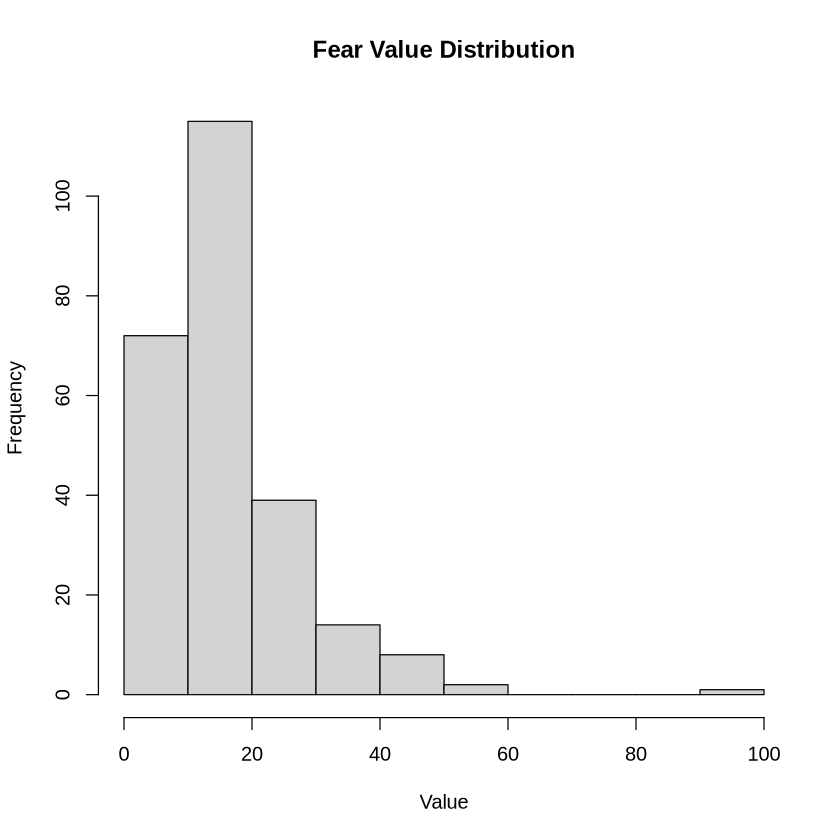

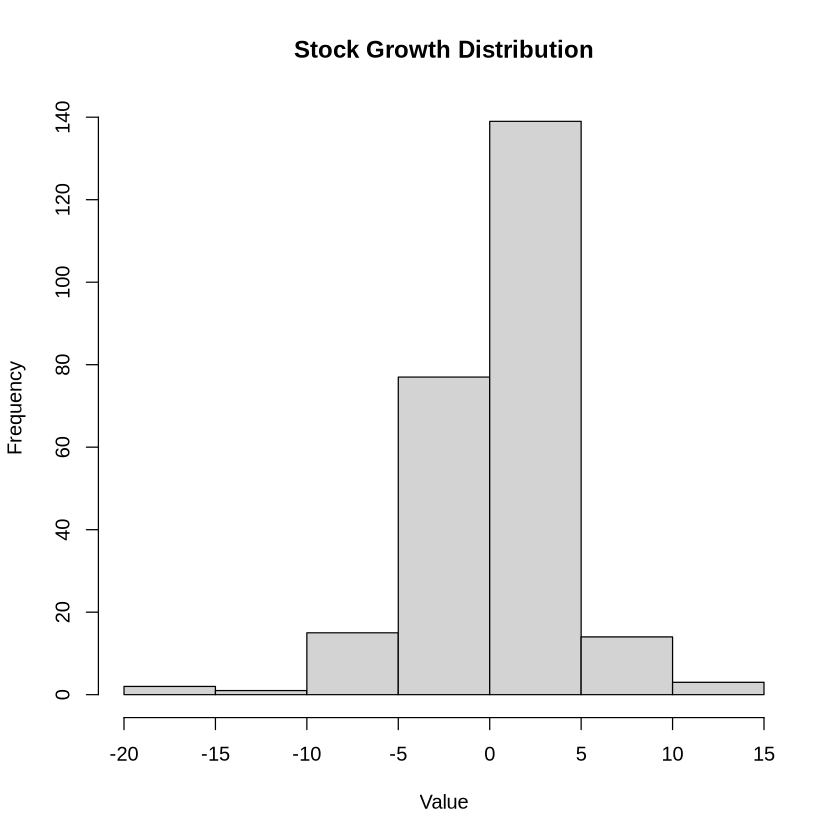

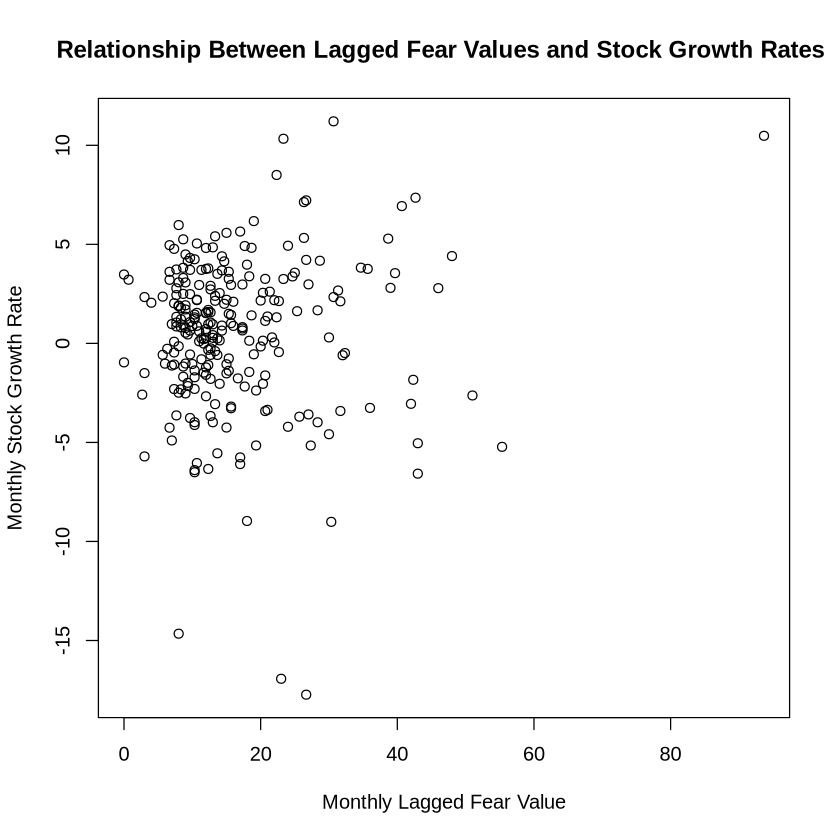

In [15]:
library(knitr) # this library helps with the integration of R code into LaTeX 
library(stargazer) #For statistic tables
library(corrr) #For correlation matrix
# Rename for readability

#Summary Table
stargazer(as.data.frame(stock_fear_data_tidy), 
          type = "text", 
          title = "Summary Statistics For Variables",
          summary = TRUE,
         out = "summary_table2.html")

#Correlation Matrix
cor_matrix <- as.data.frame(correlate(stock_fear_data_tidy, use = "complete.obs"))
stargazer(cor_matrix,
          type = "text",
          title = "Correlation Matrix For Variables",
          summary = FALSE,
          out = "correlation_table.html" )

#Histogram For Fear Values
hist(stock_fear_data_tidy$lagged_fear_value, main = "Fear Value Distribution", xlab = "Value") 

#Histogram For Stock Performance
stock_hist <- hist(stock_fear_data_tidy$stock_growth, main = "Stock Growth Distribution", xlab = "Value")

#Scatterplot 
plot(stock_fear_data_tidy$lagged_fear_value, stock_fear_data_tidy$stock_growth, 
     main="Relationship Between Lagged Fear Values and Stock Growth Rates ", xlab="Monthly Lagged Fear Value", ylab="Monthly Stock Growth Rate", col = "black")


## <u>Model Specification<u>

This section has the main regression model. 

In [17]:
# Linear regression model: stock_growth explained by lagged_fear_value and controls
model <- lm(stock_growth ~ lagged_fear_value + inflation_rate + exchange_rate + interest_rate + gdp_growth_rate + unemployment_rate +
            lagged_stock_growth,
            data = stock_fear_data_tidy)
# view the detailed results 
summary(model)


Call:
lm(formula = stock_growth ~ lagged_fear_value + inflation_rate + 
    exchange_rate + interest_rate + gdp_growth_rate + unemployment_rate + 
    lagged_stock_growth, data = stock_fear_data_tidy)

Residuals:
     Min       1Q   Median       3Q      Max 
-17.2443  -1.8769   0.4752   2.4076   9.3589 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)
(Intercept)         -3.49174    3.78675  -0.922    0.357
lagged_fear_value    0.03175    0.03015   1.053    0.293
inflation_rate      -0.21890    0.21248  -1.030    0.304
exchange_rate        0.57778    2.13529   0.271    0.787
interest_rate        0.15567    0.18475   0.843    0.400
gdp_growth_rate      0.41799    0.26310   1.589    0.113
unemployment_rate    0.41998    0.29810   1.409    0.160
lagged_stock_growth  0.01052    0.06841   0.154    0.878

Residual standard error: 3.77 on 243 degrees of freedom
Multiple R-squared:  0.04677,	Adjusted R-squared:  0.01931 
F-statistic: 1.703 on 7 and 243 DF,  p-value: 0.1

## <u>Table of Results<u>

The table below shows the regression output of the main model. The `stargazer` package has been used to present the results in a clean and legible format. 

In [19]:
# Use stargazer for a formatted regression output
library(stargazer)
stargazer(model, type = "text", title = "Regression Results: Stock Growth and Fear Index", out = "regression.html")



Regression Results: Stock Growth and Fear Index
                        Dependent variable:    
                    ---------------------------
                           stock_growth        
-----------------------------------------------
lagged_fear_value              0.032           
                              (0.030)          
                                               
inflation_rate                -0.219           
                              (0.212)          
                                               
exchange_rate                  0.578           
                              (2.135)          
                                               
interest_rate                  0.156           
                              (0.185)          
                                               
gdp_growth_rate                0.418           
                              (0.263)          
                                               
unemployment_rate              0.420   

## <u>Discussion<u>

## <u>Specification Check<u>

To ensure the validity of our regression model, we perform two specification checks:

1. Breusch-Pagan test to check for heteroskedasticity in the residuals.
2. Variance Inflation Factor (VIF) test to detect multicollinearity among independent variables.


In [31]:
library(lmtest)

bp_test <- bptest(model)
bp_test



	studentized Breusch-Pagan test

data:  model
BP = 27.014, df = 4, p-value = 1.975e-05



The p-value of the Breusch-Pagan test is 1.975e-05, which is below the 0.05 significance level. 

This indicates that there is heteroskedasticity in our model. Therefore, we need to be cautious when interpreting the regression results, as heteroskedasticity can lead to less reliable estimation.


In [33]:
library(car)

vif_values <- vif(model)
vif_values


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some




lagged_fear_value      inflation_rate       exchange_rate lagged_stock_growth 
           1.352281            1.037473            1.298256            1.063696

The VIF values for all variables are as follows:

- lagged_fear_value: 1.35
- inflation_rate: 1.04
- exchange_rate: 1.29
- lagged_stock_growth: 1.06

All VIF results are below the threshold of 5, we conclude that there is no significant multicollinearity among the independent variables in our model.


## <u>Robustness Analysis<u>

To test the robustness of our findings, we extend our model by adding an additional variable: the lagged CPI (inflation) value. 
Inflation changes, as measured by CPI, often take time to influence stock market behavior. 
When consumer prices rise, companies may not immediately adjust production or pricing strategies. Instead, it usually takes time for businesses to reflect higher costs in their operations and for consumers to respond by changing their spending habits. 
Similarly, investors react to inflation data with  delay, as they may wait for confirmation of trends and potential policy responses such as interest rate adjustments by the central bank.

By including lagged CPI in our regression model, we try to capture these delayed effects of inflation on stock market performance. This allows us to examine whether inflation's impact on stock returns is immediate or occurs over time, helping to validate the robustness of our findings.



In [39]:
stock_fear_data_tidy <- stock_fear_data_tidy %>%
  arrange(Date) %>%
  mutate(lagged_inflation = lag(inflation_rate))



In [40]:
robust_model <- lm(stock_growth ~ lagged_fear_value + inflation_rate + lagged_inflation + exchange_rate + lagged_stock_growth, data = stock_fear_data_tidy)
summary(robust_model)



Call:
lm(formula = stock_growth ~ lagged_fear_value + inflation_rate + 
    lagged_inflation + exchange_rate + lagged_stock_growth, data = stock_fear_data_tidy)

Residuals:
    Min      1Q  Median      3Q     Max 
-17.218  -1.597   0.187   2.244   9.293 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)   
(Intercept)          0.50643    2.23046   0.227   0.8206   
lagged_fear_value    0.04874    0.02595   1.878   0.0616 . 
inflation_rate       1.08222    0.55911   1.936   0.0541 . 
lagged_inflation    -1.53320    0.56573  -2.710   0.0072 **
exchange_rate        0.14136    2.00183   0.071   0.9438   
lagged_stock_growth  0.02867    0.06511   0.440   0.6601   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.739 on 244 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.05611,	Adjusted R-squared:  0.03677 
F-statistic: 2.901 on 5 and 244 DF,  p-value: 0.01453


In [41]:
library(broom)
tidy(robust_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.50642635,2.23045654,0.22705053,0.82057456
lagged_fear_value,0.04874325,0.02595416,1.87805137,0.06156676
inflation_rate,1.08222255,0.55910906,1.93561979,0.05406961
lagged_inflation,-1.53319712,0.56573331,-2.71010577,0.00720345
exchange_rate,0.14136135,2.00183339,0.07061594,0.94376127
lagged_stock_growth,0.02867139,0.06510998,0.44035330,0.66007109


The robustness analysis with lagged inflation shows improvements to our model. In the original model, our key explanatory variable, lagged fear value, had a coefficient of 0.0374 and a p-value of 0.1477, this shows that it has a positive but not statistically significant relationship with stock growth. In the robustness model, after including lagged inflation, the coefficient of lagged fear value is 0.0487, and its p-value decrease to 0.0616,  becomes more statistically significant. The overall direction and approximate magnitude of our main explanatory variable remain consistent. The robustness check confirms that our original conclusions hold, even when considering the delayed impacts of inflation, therefore, increasing the credibility of our results.


Furthermore, the lagged inflation shows a statistically significant negative effect on stock performance, with a coefficient of -1.5332 and a p-value of 0.0072. This suggests that past inflation exerts a delayed downward pressure on the stock market, this might be due to accumulated cost pressures and tighter monetary policy. The current period inflation rate shows a positive coefficient of 1.0822 and a marginal p-value of 0.0541. This difference indicates that markets may initially consider rising inflation as a sign of economic growth, but the delayed impact of inflation will have negative impact over time.

## <u>Conclusion<u>

## <u>References<u>